In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc
fontsize = 16
rc('text', usetex=True)
plt.style.use("bmh")
plt.rcParams["font.family"] = "serif"
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']



markers = {
    "CBSA":"o",
    "CBSA OpenCL":"s",
    "StochPy SSA":"+",
    "StochPy Tauleap":"P",
    "GillesPy SSA":"x",
    "GillesPy Tauleap":"X",
    "GillesPy ODE":"D",
    "STEPS SSA":"*"
}

methods = sorted(list(markers.keys()))
m_colors = {methods[i]:colors[i] for i in range(len(methods))}

In [3]:
file = "diffusion_benchmark_results.json"
with open(file) as f:
    data = json.load(f)

In [4]:
output_tmp_file = "diffusion_benchmark_results.tmp"
data = {}
with open(output_tmp_file) as f:
    exp_id = None
    for line in f.readlines():
        if line[0] == "#":
            exp_id = line.split(" ")[1][:-1]
        else:
            if exp_id in data.keys():
                print("WARNING: duplicated Experiment ID: "+exp_id)
            data[exp_id] = json.loads(line)
with open(output_tmp_file.replace("tmp","json"),'w') as f:
    json.dump(data,f)

In [5]:
print(len(data))

152


In [6]:
def get_pca(data,labels,projections = 2):
    
    data = np.array(data)
    if np.any(data<0):
        print("Warning: negative values")
    
    std_data = (data - np.mean(data)) / np.std(data)
    
    covariance_matrix = np.cov(std_data.T)
    
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    
    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:,idx]
    
    variance_explained = []
    for i in eigen_values:
        variance_explained.append(np.round((i/sum(eigen_values))*100,2))
    variance_explained = np.array(variance_explained)
    
    projection_matrix = (eigen_vectors.T[:][:2]).T
    
    pca = std_data.dot(projection_matrix)
    
    pca_data = {}
    for m in list(set(labels)):
        plot_data = []
        for i in range(pca.shape[0]):
            if m == labels[i]:
                plot_data.append(pca[i])
        plot_data = np.array(plot_data)
        pca_data[m] = plot_data[:,:projections]
    
    return variance_explained[:projections],pca_data
    
def get_experiment(data,experiment):    
    times = {}
    results = {}
    methods = {}
    for exp in data.values():
        if exp["Experiment Type"] == experiment:
            sim_method = exp["Simulation Method"]
            result = exp["Result"]
            if type(result) is str:
                print(sim_method,result)
                continue
            
            abort = False
            for r in result:
                if type(r) is str:
                    print(sim_method,r)
                    abort = True
                    break
            if abort:
                continue
                
            result = np.array(result)
            
            if exp["Changing Parameter"] == "None":
                sim_parameter = exp["Changing Parameter"]
            else:
                sim_parameter = exp["Model Generator Parameters"][exp["Changing Parameter"]]
            

            if sim_method not in times.keys():
                times[sim_method] = {}

            if sim_parameter not in results.keys():
                results[sim_parameter] = []
                methods[sim_parameter] = []
                
            times[sim_method][sim_parameter] = np.array(result[:,0])    
            for i in range(result.shape[0]):
                results[sim_parameter].append(result[i][1:])
                methods[sim_parameter].append(sim_method)
    return times,results,methods



StochPy Tauleap simulation error


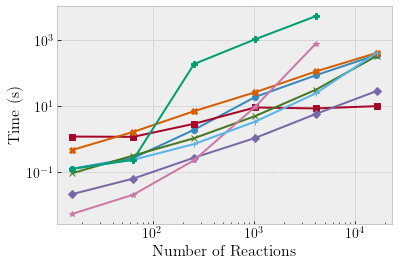

In [7]:

n_reaction_times,n_reaction_results,n_reaction_methods = get_experiment(data,"Number of Reactions")
        
for m in sorted(list(n_reaction_times.keys())):
    r = n_reaction_times[m]
    x = list(r.keys())
    y = [np.mean(r[i]) for i in list(r.keys())]
    x = [(i**2)*4 for i in x]
    plt.plot(x,y,label=m,marker=markers[m])
#plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Number of Reactions",fontsize=fontsize)
plt.ylabel("Time (s)",fontsize=fontsize)

plt.savefig("diffusion_n_reactions.png",dpi=300, bbox_inches='tight',transparent=True)
plt.show()

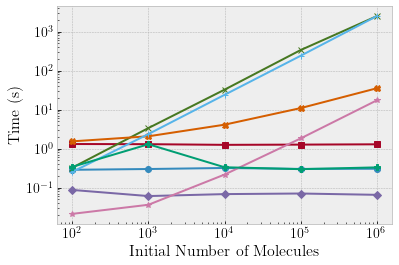

In [8]:
init_mol_times,init_mol_results,init_mol_methods = get_experiment(data,"Initial Molecules")
        
for m in sorted(list(init_mol_times.keys())):
    r = init_mol_times[m]
    x = list(r.keys())
    y = [np.mean(r[i]) for i in x]
    plt.plot(x,y,label=m,marker=markers[m])
#plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Initial Number of Molecules",fontsize=fontsize)
plt.ylabel("Time (s)",fontsize=fontsize)
plt.savefig("diffusion_init_mol.png",dpi=300, bbox_inches='tight',transparent=True)
plt.show()


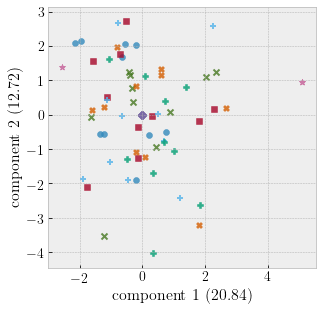

In [9]:
init_mol_variance_explained,init_mol_pca = get_pca(init_mol_results[100],init_mol_methods[100])
plt.figure(figsize=[4.8, 4.8])
for m in sorted(list(init_mol_pca.keys())):
    plt.scatter(init_mol_pca[m][:,0],init_mol_pca[m][:,1],label=m,marker=markers[m],alpha=0.8)
plt.xlabel("component 1 ("+str(init_mol_variance_explained[0])+")",fontsize=fontsize)
plt.ylabel("component 2 ("+str(init_mol_variance_explained[1])+")",fontsize=fontsize)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("diffusion_init_mol_100_pca.png",dpi=300, bbox_inches='tight',transparent=True)
plt.show()

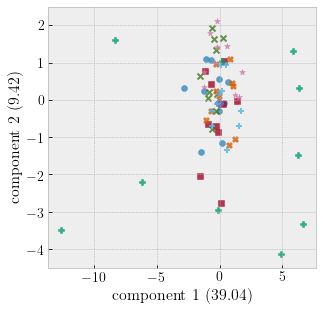

In [10]:
init_mol_variance_explained,init_mol_pca = get_pca(init_mol_results[1000000],init_mol_methods[1000000])
plt.figure(figsize=[4.8, 4.8])
for m in sorted(list(init_mol_pca.keys())):
    plt.scatter(init_mol_pca[m][:,0],init_mol_pca[m][:,1],label=m,marker=markers[m],alpha=0.8)
plt.xlabel("component 1 ("+str(init_mol_variance_explained[0])+")",fontsize=fontsize)
plt.ylabel("component 2 ("+str(init_mol_variance_explained[1])+")",fontsize=fontsize)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("diffusion_init_mol_1kk_pca.png",dpi=300, bbox_inches='tight',transparent=True)
plt.show()

CBSA OpenCL simulation error


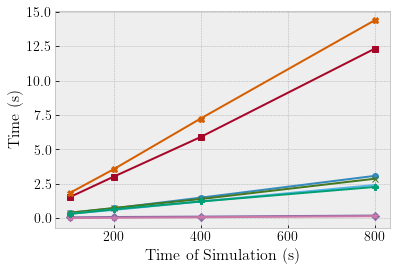

In [30]:
sim_time_times,sim_time_results,sim_time_methods = get_experiment(data,"Simulation Time")
        
for m in sorted(list(sim_time_times.keys())):
    r = sim_time_times[m]
    x = list(r.keys())
    y = [np.mean(r[i]) for i in x]
    plt.plot(x,y,label=m,marker=markers[m])
#plt.legend()
#plt.ylim(0,400)
#plt.yscale('log')
plt.xlabel("Time of Simulation (s)",fontsize=fontsize)
plt.ylabel("Time (s)",fontsize=fontsize)
plt.savefig("diffusion_sim_time.png",dpi=300, bbox_inches='tight',transparent=True)
plt.show()


#for parameter in sim_time_results.keys():
#    plot_pca(sim_time_results[parameter],sim_time_methods[parameter])

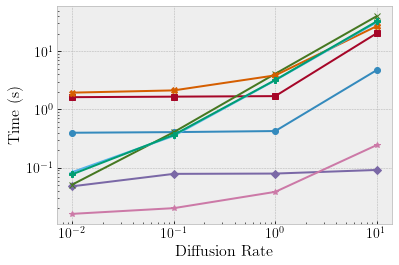

In [12]:
diff_const_times,diff_const_results,diff_const_methods = get_experiment(data,"Diffusion Constant")
        
for m in sorted(list(diff_const_times.keys())):
    r = diff_const_times[m]
    x = list(r.keys())
    y = [np.mean(r[i]) for i in x]
    plt.plot(x,y,label=m,marker=markers[m])
#plt.legend()
#plt.ylim(0,400)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Diffusion Rate',fontsize=fontsize)
plt.ylabel("Time (s)",fontsize=fontsize)
plt.savefig("diffusion_kdiff.png",dpi=300, bbox_inches='tight',transparent=True)
plt.show()


#for parameter in diff_const_results.keys():
#    plot_pca(diff_const_results[parameter],diff_const_methods[parameter])

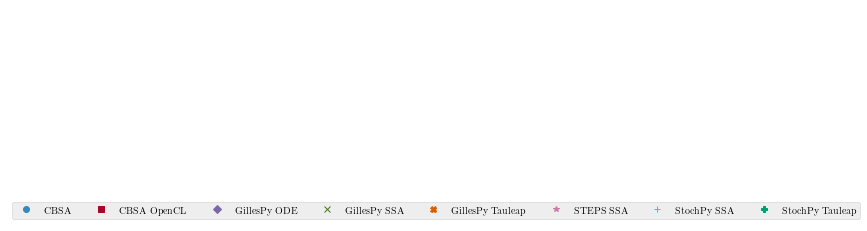

In [13]:
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f(markers[m], m_colors[m]) for m in methods]
labels = methods
legend = plt.legend(handles, labels, loc=3,ncol=len(labels), framealpha=1, frameon=True)

def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=300, bbox_inches=bbox,transparent=True)


plt.box(on=None)
plt.grid(False, which='major', axis='both')
plt.tick_params(axis='both', length = 0)
plt.xticks([])
plt.yticks([])
export_legend(legend,filename="diffusion_legend.png")
plt.show()

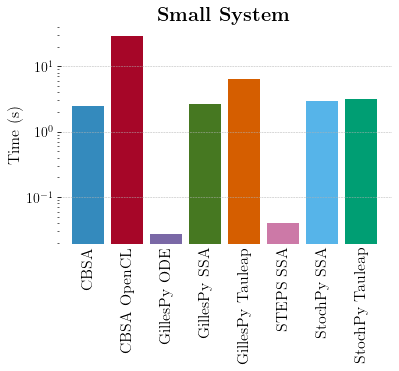

In [28]:
worst_case_file = "worst_scenario_benchmark_results.json"
with open(worst_case_file) as f:
    worst_case_data = json.load(f)
    
worst_case_times,worst_case_results,worst_case_methods = get_experiment(worst_case_data,"Worst Scenario")
parameter = "None"

labels = sorted(list(worst_case_times.keys()))
x = range(len(labels))
y = [np.mean(worst_case_times[m][parameter]) for m in labels]
plt.bar(x,y,color=[m_colors[m] for m in labels])
plt.yscale('log')
plt.xticks(x, labels, rotation='vertical',fontsize=fontsize)
plt.ylabel("Time (s)",fontsize=fontsize)
plt.title(r'\textbf{Small System}',fontsize=20)
plt.box(on=None)
plt.grid(False, which='major', axis='x')
plt.tick_params(axis='x', length = 0)
plt.savefig("diffusion_worst_case.png",dpi=300, bbox_inches='tight',transparent=True)
plt.show()


StochPy Tauleap simulation error
StochPy SSA simulation error
GillesPy SSA timeout 600


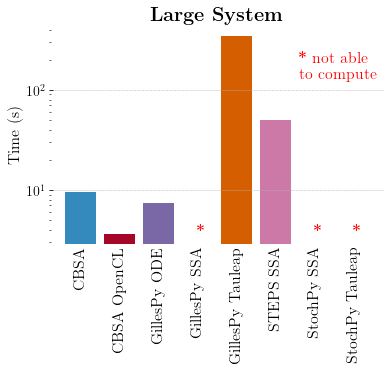

In [29]:
best_case_file = "best_scenario_benchmark_results.json"
with open(best_case_file) as f:
    best_case_data = json.load(f)

best_case_times,best_case_results,best_case_methods = get_experiment(best_case_data,"Best Scenario")
parameter = "None"

labels = methods
x = range(len(labels))
y = []
for m in labels:
    if m in best_case_times.keys():
        y.append(np.mean(best_case_times[m][parameter]))
    else:
        y.append(0)
plt.bar(x,y,color=[m_colors[m] for m in labels])
for i in x:
    if not y[i]:
        plt.text(i,4,r'\textbf{*}',color="r",fontsize=fontsize)
        
plt.text(5.6,130,r'\textbf{*} not able'+"\n"+ r'to compute',color="r",fontsize=fontsize)
plt.yscale('log')
plt.xticks(x, labels, rotation='vertical',fontsize=fontsize)
plt.ylabel("Time (s)",fontsize=fontsize)
plt.title(r'\textbf{Large System}',fontsize=20)
plt.box(on=None)
plt.grid(False, which='major', axis='x')
plt.tick_params(axis='x', length = 0)
plt.savefig("diffusion_best_case.png",dpi=300, bbox_inches='tight',transparent=True)
plt.show()


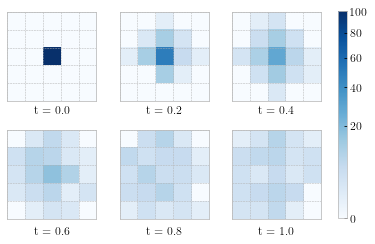

In [27]:
from sys import path as syspath
from os import path as ospath

#CBSA
syspath.append(ospath.join(ospath.expanduser("~"), 'CBSA'))
from cbsa import ReactionSystem

sqrt_spaces = 5
m = 100
diffusion_k = 1.
max_dt = 0.1
sim_time = 2

S = [[0]]
R = [[0]]

x = [0]
k = [0.]
diff_k = [diffusion_k]

cbsa = ReactionSystem(S,R)
cbsa.setup(sqrt_spaces**2,'toroid')

cbsa.set_x(x)
cbsa.set_k(k,diff_k)
cbsa.set_max_dt(max_dt)

cbsa.exp_x0[13] = m

cbsa.setup_simulation(use_opencl=False)
cbsa.compute_simulation(sim_time)
cbsa_sim_data = np.array(cbsa.simulation_data)

import matplotlib.colors as colors

widths = [1,1,1]
heights = [1,1]

gs_kw = dict(width_ratios=widths, height_ratios=heights)

fig, axs = plt.subplots(ncols=3, nrows=2, sharex=True,sharey=True,gridspec_kw=gs_kw)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.xticks(range(6))
plt.yticks(range(6))

times = [0.0,0.2,0.4,0.6,0.8,1.0]
time_idx = [np.searchsorted(cbsa_sim_data[:,0],t,side="left") for t in times]
for i, ax in enumerate(axs.flatten()):
    ax.set_facecolor('w')
    ax.set_xlabel("t = "+str(round(cbsa_sim_data[time_idx[i],0],1)),fontsize=12)
    pos = ax.imshow(cbsa_sim_data[time_idx[i],1:].reshape((sqrt_spaces,sqrt_spaces)), cmap='Blues', interpolation='none',vmin=0, vmax=m ,norm=colors.PowerNorm(gamma=0.5),extent=[0,5,0,5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis=u'both', which=u'both',length=0)

fig.subplots_adjust(right=0.8,bottom=0.2)
cbar_ax = fig.add_axes([0.84, 0.215, 0.02, 0.72])
lgd = fig.colorbar(pos, cax=cbar_ax)
cbar_ax.tick_params(axis=u'y', labelsize=12)

plt.savefig("diffusion.png",dpi=300, bbox_inches='tight',transparent=True)
plt.show()